<a href="https://colab.research.google.com/github/ChyavanShenoy/AAI-500-Final-Project/blob/main/Project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final project AAI-500

Members:   
- Chyavan Shenoy
- Koelgeet Kaur

# Imports

In [1]:
!export LC_ALL=en_US.UTF-8
!export LANG=en_US.UTF-8

/bin/bash: line 1: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8): No such file or directory


In [2]:
%pip install pandas numpy seaborn matplotlib scikit_learn imblearn xgboost plotly

/home/chyavanshenoy/Projects/Uni-Projects/AAI-500-Final-Project/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.impute import SimpleImputer
# from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import xgboost as xgb
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
import joblib
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE

# Loading Dataset

In [4]:
df = pd.read_csv('AQI_dataset.csv')
df.head()

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category,lat,lng
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate,44.7444,44.2031
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good,-5.2900,-44.4900
2,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good,-11.2958,-41.9869
3,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate,37.1667,15.1833
4,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good,53.0167,20.8833


In [5]:
df.describe()

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,lat,lng
count,16695.000000,16695.000000,16695.000000,16695.000000,16695.000000,16695.000000,16695.000000
mean,62.998682,1.342138,31.767355,3.819647,59.821324,30.267148,-3.944485
std,43.091971,2.371379,22.839343,5.880677,43.208298,22.947398,73.037148
min,7.000000,0.000000,0.000000,0.000000,0.000000,-54.801900,-171.750000
25%,38.500000,1.000000,20.000000,0.000000,34.000000,16.515450,-75.180000
50%,52.000000,1.000000,29.000000,2.000000,52.000000,38.815800,5.643100
75%,69.000000,1.000000,38.000000,5.000000,69.000000,46.683300,36.275000
max,500.000000,133.000000,222.000000,91.000000,500.000000,70.767000,178.017800


Here we are `defining` the `columns of interest` for our Machine Learning models

In [6]:
learning_vars = ['PM2.5 AQI Value', 'NO2 AQI Value', 'Ozone AQI Value', 'CO AQI Value']
target_classification = 'AQI Category'
target_regression = 'AQI Value'
fix_columns = ['PM2.5 AQI Value', 'NO2 AQI Value', 'Ozone AQI Value', 'CO AQI Value', 'AQI Value']

# Data Exploration

In [7]:
print(df.isnull().sum())

Country               302
City                    0
AQI Value               0
AQI Category            0
CO AQI Value            0
CO AQI Category         0
Ozone AQI Value         0
Ozone AQI Category      0
NO2 AQI Value           0
NO2 AQI Category        0
PM2.5 AQI Value         0
PM2.5 AQI Category      0
lat                     0
lng                     0
dtype: int64


# Data Clean up

- Since we do not require the `Country`, `City`, `lat`, and `lng` columns in the dataset, we can drop them, hence reducing the number of features the ML model has to learn, in turn reducing the time required.

In [8]:
print(df.isnull().sum())

Country               302
City                    0
AQI Value               0
AQI Category            0
CO AQI Value            0
CO AQI Category         0
Ozone AQI Value         0
Ozone AQI Category      0
NO2 AQI Value           0
NO2 AQI Category        0
PM2.5 AQI Value         0
PM2.5 AQI Category      0
lat                     0
lng                     0
dtype: int64


# Data visualizing

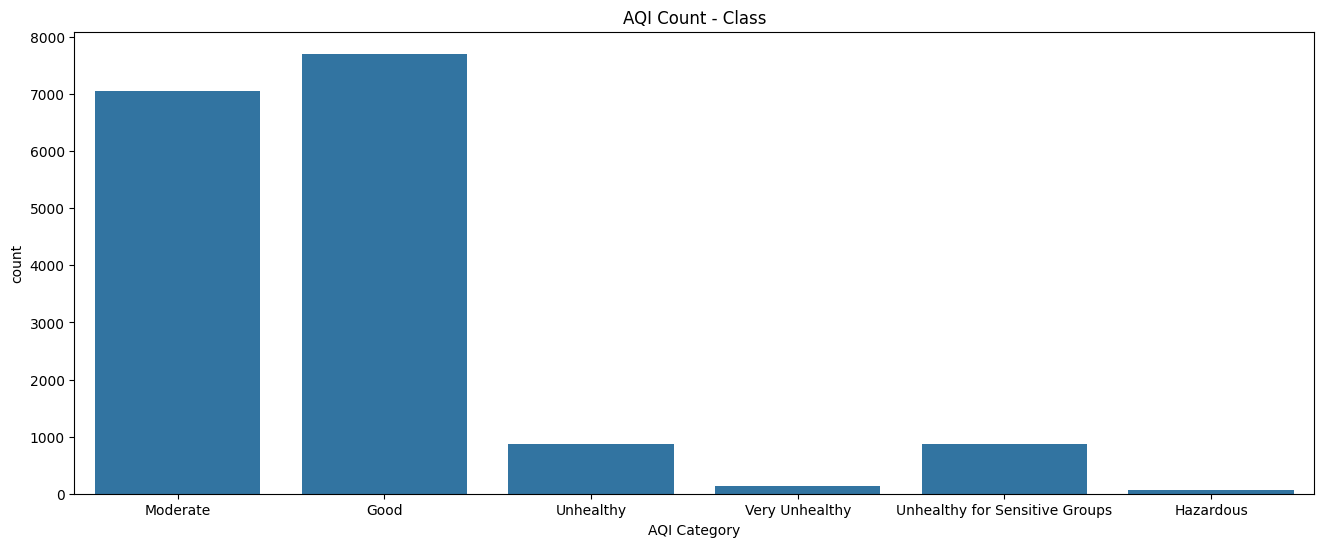

In [9]:
plt.figure(figsize=(16,6))
sns.countplot(x='AQI Category', data=df)
plt.title("AQI Count - Class")
plt.show()

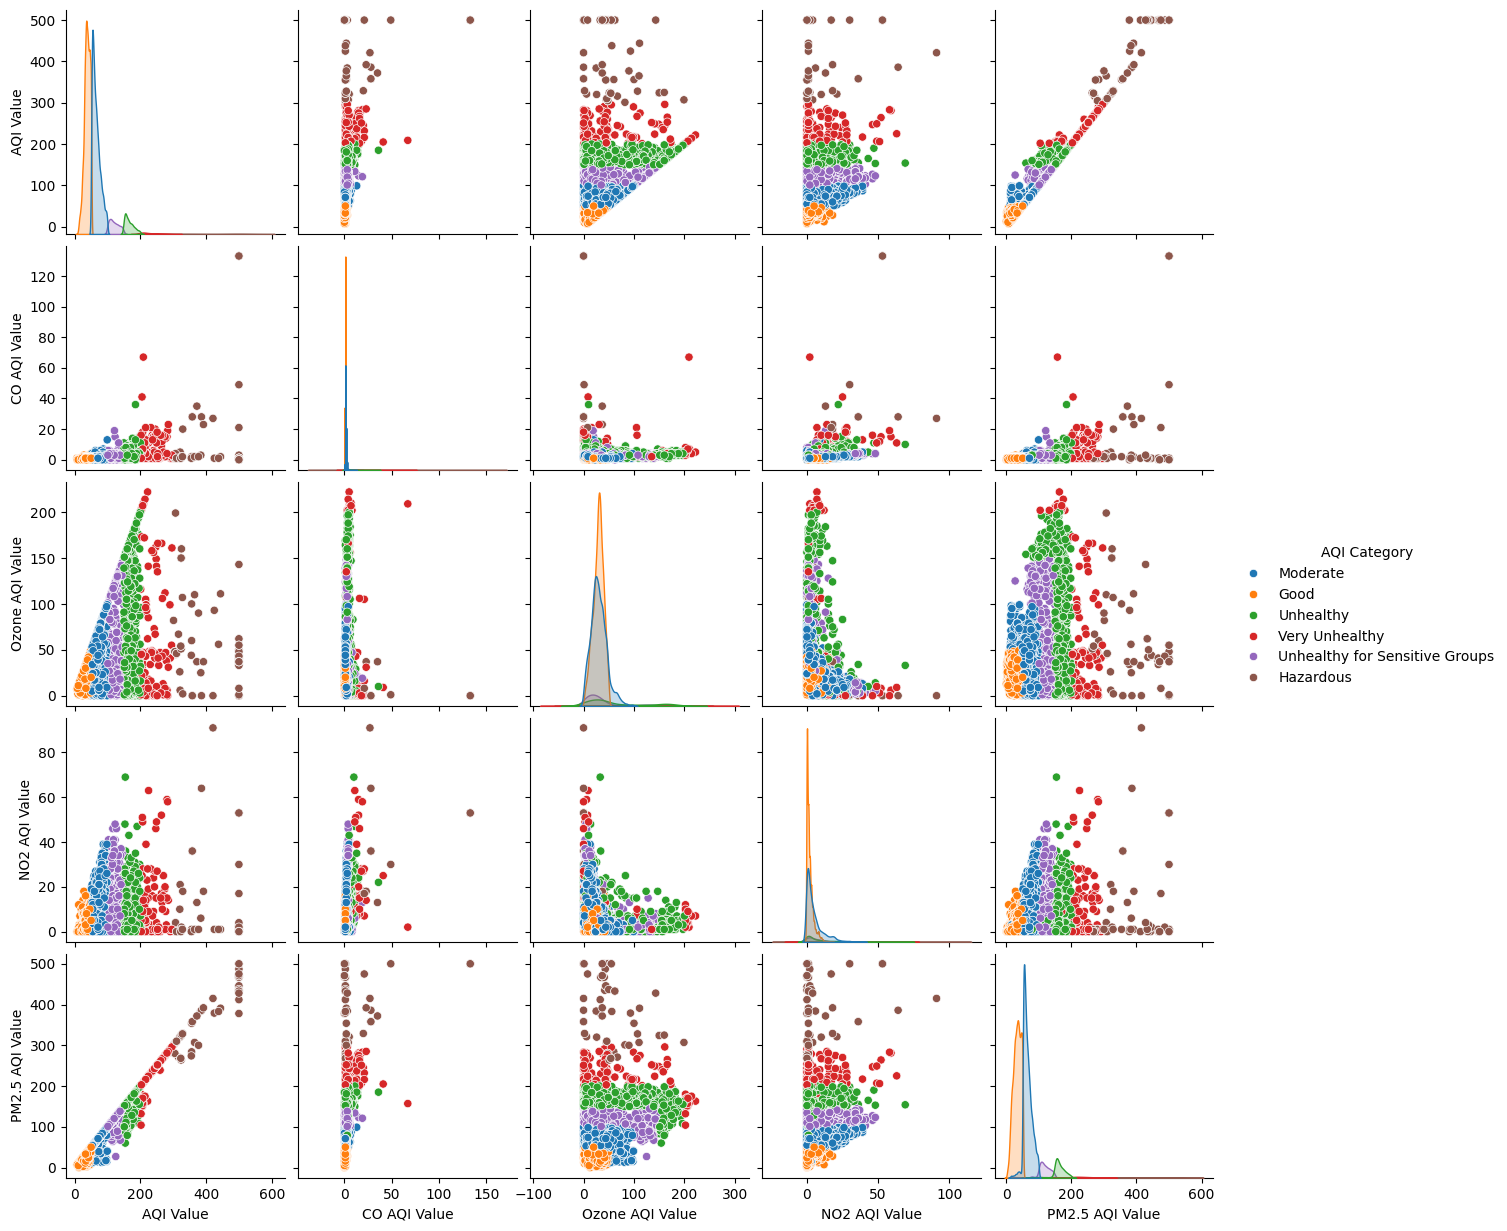

In [10]:
df = df.drop(columns=['Country', 'City', 'lat', 'lng'])
sns.pairplot(df, hue='AQI Category')
plt.show()

In [11]:
df['AQI Category'].unique()

array(['Moderate', 'Good', 'Unhealthy', 'Very Unhealthy',
       'Unhealthy for Sensitive Groups', 'Hazardous'], dtype=object)

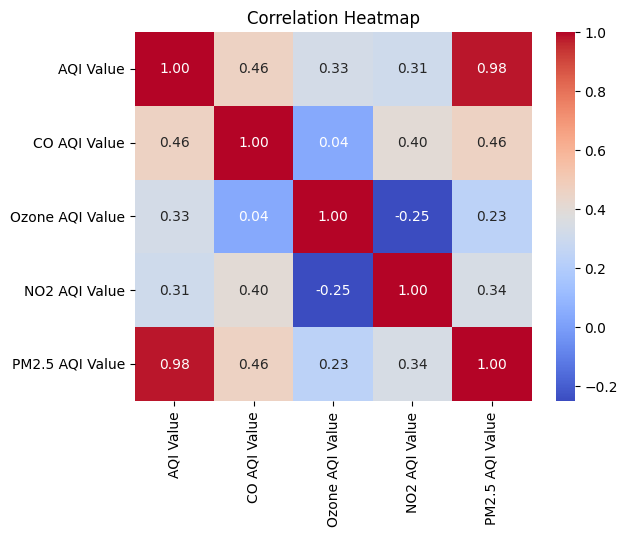

In [12]:
num_df = df.select_dtypes(include='number')
sns.heatmap(num_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

We are using `dropna()` since it provided us the best accuracy, and we `didn't lose out` on many datapoints that made much difference.

Initially we had chose 3 strategies: `Simple Imputer`, `K-NN Imputer`, and `Drop NaN`.   

In [13]:
# imputer = SimpleImputer(strategy='mean')
# df[fix_columns] = imputer.fit_transform(df[fix_columns])

# knn_imputer = KNNImputer(n_neighbors=5)
# df[fix_columns] = knn_imputer.fit_transform(df[fix_columns])

df = df.dropna()

We make use of `LabelEncoder()` to make it easier for the models to learn data. Since `models perform better` with `number` than `words`, for classification, we encode each class with a numerical value.

In [14]:
label_encoder = LabelEncoder()
df[target_classification] = label_encoder.fit_transform(df[target_classification])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16695 entries, 0 to 16694
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   AQI Value           16695 non-null  int64 
 1   AQI Category        16695 non-null  int64 
 2   CO AQI Value        16695 non-null  int64 
 3   CO AQI Category     16695 non-null  object
 4   Ozone AQI Value     16695 non-null  int64 
 5   Ozone AQI Category  16695 non-null  object
 6   NO2 AQI Value       16695 non-null  int64 
 7   NO2 AQI Category    16695 non-null  object
 8   PM2.5 AQI Value     16695 non-null  int64 
 9   PM2.5 AQI Category  16695 non-null  object
dtypes: int64(6), object(4)
memory usage: 1.3+ MB


In [16]:
df.head()

,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
0,51,2,1,Good,36,Good,0,Good,51,Moderate
1,41,0,1,Good,5,Good,1,Good,41,Good
2,41,0,1,Good,5,Good,1,Good,41,Good
3,66,2,1,Good,39,Good,2,Good,66,Moderate
4,34,0,1,Good,34,Good,0,Good,20,Good


`Splitting` dataset into `train` and `test`. We will be using `80:20` ratio to perform the split.

In [17]:
X = df[learning_vars]

y_class = df[target_classification]
y_reg = df[target_regression]

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=0)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=0)

Here we have attempted to do some sampling to balancing the dataset to get somewhat an equal number of classes across the dataset. We found that for our dataset of choice, the SMOTE sampling actually harms the predictions, rather than helping it perform better.   

What ended up happening is that, while it tried it's best to balance the datset by creating synthetic data, it ended up introducing more noise than actual relationship between the columns. Hence the predictions were way off.

In [18]:
# smote = SMOTE(random_state=0)
# X_train_class, y_train_class = smote.fit_resample(X_train_class, y_train_class)

# adasyn = ADASYN(random_state=0)
# X_train_class, y_train_class = adasyn.fit_resample(X_train_class, y_train_class)

# borderline_smote = BorderlineSMOTE(random_state=0)
# X_train_class, y_train_class = borderline_smote.fit_resample(X_train_class, y_train_class)

In [19]:
X.head()

,PM2.5 AQI Value,NO2 AQI Value,Ozone AQI Value,CO AQI Value
0,51,0,36,1
1,41,1,5,1
2,41,1,5,1
3,66,2,39,1
4,20,0,34,1


In [20]:
scaler = StandardScaler()
X_train_class = scaler.fit_transform(X_train_class)
X_test_class = scaler.transform(X_test_class)
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)

# **Model Description & Codes**

## **Logistic Regression Model**


Logistic Regression is a supervised learning algorithm designed for binary classification tasks,
Here the goal is to model the relationship between independent variables known as features and dependent variables known as outcome. But instead of predicting the exact number, it predicts the likelihood that the outcome will belong to which class.
Logistic Regression is a classification algorithm and not a regression algorithm unlike suggested by its name and it is used to  estimate the likelihood that a given input belongs to a certain class.

Logistic Regression works on certain key assumptions:

*   **Linearity of the independent variable and log-odds:** This algorithm
      assume that the independent variables and log-odds follow a linear relationship.
*   **Independence of observations:** The model assumes that the observations  
      in the dataset are independent of each other.

*   **No multicollinearity:** The independent variables should not be highly correlated with each other.


**Advantages**


*   Logistic regression is easy to implement and provides interpretable outputs.
*   The probabilistic outcomes can be used to make decisions which require the estimation of confidence intervals.
*   Very efficient on linearly separable data.


**Disadvantages**

*   Not suitable for non-linear data and for datasets with complex relationships between variables.
*   Highly sensitive to outliers especially for smaller datasets.


**Model Performance:** The Logistic Regression model achieved an accuracy of 94% on the test set.


In [21]:
logistic_model = LogisticRegression(max_iter=2000)
logistic_model.fit(X_train_class, y_train_class)
y_pred_class_logistic = logistic_model.predict(X_test_class)
print("Logistic Regression Classification Report:")
print(classification_report(y_test_class, y_pred_class_logistic, zero_division=1))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1548
           1       0.89      0.89      0.89         9
           2       0.91      0.94      0.93      1415
           3       0.87      0.94      0.91       176
           4       0.87      0.78      0.82       167
           5       0.94      0.67      0.78        24

    accuracy                           0.92      3339
   macro avg       0.91      0.86      0.88      3339
weighted avg       0.93      0.92      0.92      3339



## **Decision Tree Model**

The decision tree is a non-parametric, supervised learning algorithm which is widely used for both classification and regression tasks. It works by building a tree-like model for taking decisions.

The root node is chosen based on the feature that provides the highest information gain. At each internal node (the pink one of the above figure), the dataset is split recursively based on the feature that best separates the data into distinct classes.The process continues until a stopping criterion is met (either the maximum depth or a minimum number of samples per leaf).

Here each internal node represents a decision based on a specific feature and the leaf node represents the final outcome.


**Advantages:-**

*   Decision trees are easy to understand, visualize, and interpret.
*   it can be used to handle both categorical and numerical data.

**Disadvantages:-**

*   But it is prone to overfitting and is highly sensitive to small changes in the dataset. Hence it can create biased trees in imbalanced data which leads to inaccurate results.

**Hyperparameter Tuning:** The key hyperparameters, including max_depth, min_sample_leaf and min_samples_split were tuned. The final parameters were values are:


*   max_depth = 10
*   min_sample_leaf  = 3
*   min_samples_split = 90

**Model Performance:** The Decision Tree model achieved an accuracy of 100 % on the test set, with the following performance metrics:


*   R2-score = 0.977
*   MSE = 43.286.
















**Classification Task**

In [22]:
dtree_classifier = DecisionTreeClassifier(random_state=0,max_depth=7,min_samples_split=70)
dtree_classifier.fit(X_train_class, y_train_class)
y_pred_class_dtree=dtree_classifier.predict(X_test_class)
print("Decision Tree Classification Report:")
print(classification_report(y_test_class, y_pred_class_dtree, zero_division=0))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1548
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00      1415
           3       0.99      0.97      0.98       176
           4       0.96      0.99      0.98       167
           5       0.96      0.96      0.96        24

    accuracy                           1.00      3339
   macro avg       0.99      0.97      0.98      3339
weighted avg       1.00      1.00      1.00      3339



**Regression Task**

In [23]:
dtree_regressor = DecisionTreeRegressor(random_state=0,max_depth=10,min_samples_leaf=3,min_samples_split=90)
dtree_regressor.fit(X_train_reg, y_train_reg)
y_pred_reg_dt=dtree_regressor.predict(X_test_reg)
print("Decision Tree Regression Metrics:")
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg_dt))
print("R2 Score:", r2_score(y_test_reg, y_pred_reg_dt))

Decision Tree Regression Metrics:
MSE: 48.657003626349855
R2 Score: 0.9731237911662257


## **Random Forest Model**

Random Forest is an ensemble learning algorithm meaning it combines predictions from multiple decision trees to make a more accurate prediction. It can be used for both classification and regression tasks and is particularly effective in handling large datasets with complex relationships between the variables.

Random Forest uses the Bootstrapping technique where multiple samples are taken from the training dataset with replacement to build the decision trees. For each tree, a random subset of features is considered ensuring improvement in the overall performance. For classification tasks, the predictions of individual trees are combined using majority voting. For regression tasks, the average of the trees predictions is used as the final output.

**Advantages:**


*   Reduces Overfitting. Hence makes the model more generalized.
*   Random Forest is effective with high dimensionality datasets.
*   It is less sensitive to outliers because of the averaging technique used.

**Disadvantages:**

*   May not perform well on smaller datasets.
*   Since it has to train multiple decision trees, it is computationally expensive and requires long time to train.

**Hyperparameter Tuning:** The key hyperparameter  n_estimators was tuned. The final parameter were value is:

*   n_estimators = 100

**Model Performance:** The Random Forest model achieved an overall accuracy of 100% on the test set, with the following performance metrics:

* R2-score = 0.99
* MSE = 3.644














**Classification Task**

In [24]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train_class, y_train_class)
y_pred_class_rf = rf_classifier.predict(X_test_class)
print("Random Forest Classification Report:")
print(classification_report(y_test_class, y_pred_class_rf, zero_division=1))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1548
           1       0.90      1.00      0.95         9
           2       1.00      1.00      1.00      1415
           3       0.99      1.00      1.00       176
           4       1.00      0.99      1.00       167
           5       1.00      0.92      0.96        24

    accuracy                           1.00      3339
   macro avg       0.98      0.99      0.98      3339
weighted avg       1.00      1.00      1.00      3339



**Regression Task**

In [25]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_reg, y_train_reg)
y_pred_reg_rf = rf_regressor.predict(X_test_reg)
print("Random Forest Regression Metrics:")
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg_rf))
print("R2 Score:", r2_score(y_test_reg, y_pred_reg_rf))

Random Forest Regression Metrics:
MSE: 1.0053473794549268
R2 Score: 0.9994446857778541


## **Extreme Gradient Boosting Model (XGBoost)**

Boosting is an ensemble machine learning technique that focuses on improving the accuracy of prediction by combining multiple simple models “weak learners” to create the final outcome.

The boosting technique starts with a simple model (small tree) and gradually increases indicating gradual improvement with each tree. Each tree is built on the error of the previous tree and the final prediction is made by combining decisions from all the weak learners to get the final prediction which is strong and accurate.

XGBoost (Extreme Gradient Boosting) is an extremely efficient and scalable implementation of the gradient boosting algorithm. It is designed for both classification and regression tasks and is widely used for tabular datasets. This algorithm is designed to maximize computational speed and improve the performance of the model by using optimization techniques such as parallelized tree boosting, regularization and its ability to handle sparse data.

**Advantages:**

*   Highly efficient, scalable, handles sparse data, supports parallel computation, and prevents overfitting
*  Efficiently handles missing data by automatically learning the best direction for missing values.

**Disadvantage:**

*   While XGBoost is optimized for speed, it can still be computationally expensive on very large datasets or with a large number of trees.

**Hyperparameter Tuning:** The key hyperparameters, including max_depth, n_estimators, and learning_rate, were tuned. The final parameters were values are:

*   max_depth = 10
*   n_estimators = 100
*    learning_rate = 0.1

**Model Performance:** The XGBoost model achieved an accuracy of 99% on the test set, with the following performance metrics:
*   R2-score = 0.9846
*   MSE = 29.325


**Classification Task**

In [26]:
xgb_classifier = xgb.XGBClassifier(random_state=0,max_depth=10,learning_rate=0.1,n_estimators= 100)
xgb_classifier.fit(X_train_class, y_train_class)
y_pred_class_xgb=xgb_classifier.predict(X_test_class)
print("XGBoost Classification Report:")
print(classification_report(y_test_class, y_pred_class_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1548
           1       0.82      1.00      0.90         9
           2       1.00      1.00      1.00      1415
           3       0.98      0.98      0.98       176
           4       0.98      0.96      0.97       167
           5       0.83      0.79      0.81        24

    accuracy                           0.99      3339
   macro avg       0.93      0.96      0.94      3339
weighted avg       0.99      0.99      0.99      3339



**Regression Task**

In [27]:
xgb_regressor = xgb.XGBRegressor(random_state=0,max_depth=5,n_estimators= 100)
xgb_regressor.fit(X_train_reg, y_train_reg)
y_pred_reg_xgb=xgb_regressor.predict(X_test_reg)
print("XGBoost Regression Metrics:")
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg_xgb))
print("R2 Score:", r2_score(y_test_reg, y_pred_reg_xgb))

XGBoost Regression Metrics:
MSE: 20.90039457381896
R2 Score: 0.9884554743766785


## **Multi Layer Perceptron**

**Classification Task**

In [28]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_classifier.fit(X_train_class, y_train_class)
y_pred_class_mlp = mlp_classifier.predict(X_test_class)
print("MLP Classification Report:")
print(classification_report(y_test_class, y_pred_class_mlp, zero_division=1))

MLP Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1548
           1       0.89      0.89      0.89         9
           2       1.00      1.00      1.00      1415
           3       0.97      0.99      0.98       176
           4       0.98      0.96      0.97       167
           5       0.91      0.88      0.89        24

    accuracy                           1.00      3339
   macro avg       0.96      0.95      0.96      3339
weighted avg       1.00      1.00      1.00      3339



**Regression Task**

In [29]:
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
mlp_regressor.fit(X_train_reg, y_train_reg)
y_pred_reg_mlp = mlp_regressor.predict(X_test_reg)
print("MLP Regression Metrics:")
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg_mlp))
print("R2 Score:", r2_score(y_test_reg, y_pred_reg_mlp))

MLP Regression Metrics:
MSE: 2.5683110593932983
R2 Score: 0.9985813663144484


**Dual prediction**

In [30]:
y_dual = df[[target_classification, target_regression]]
X_train_dual, X_test_dual, y_train_dual, y_test_dual = train_test_split(X, y_dual, test_size=0.2, random_state=42)

X_train_dual = scaler.fit_transform(X_train_dual)
X_test_dual = scaler.transform(X_test_dual)

mlp_dual = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_dual.fit(X_train_dual, y_train_dual)
y_pred_dual = mlp_dual.predict(X_test_dual)

print("MLP Dual Prediction Metrics:")
print("MSE (AQI_Bucket):", mean_squared_error(y_test_dual[target_classification], y_pred_dual[:, 0]))
print("MSE (AQI):", mean_squared_error(y_test_dual[target_regression], y_pred_dual[:, 1]))

MLP Dual Prediction Metrics:
MSE (AQI_Bucket): 0.2759964188563675
MSE (AQI): 1.9361465814629797


In [31]:
joblib.dump(logistic_model, 'logistic_model.pkl')
joblib.dump(dtree_classifier,'dtree_classifier.pkl')
joblib.dump(dtree_regressor,'dtree_regressor.pkl')
joblib.dump(rf_classifier, 'rf_classifier.pkl')
joblib.dump(rf_regressor, 'rf_regressor.pkl')
joblib.dump(xgb_classifier,'xgb_classifier.pkl')
joblib.dump(xgb_regressor,'xgb_regressor.pkl')
joblib.dump(mlp_classifier, 'mlp_classifier.pkl')
joblib.dump(mlp_regressor, 'mlp_regressor.pkl')
joblib.dump(mlp_dual, 'mlp_dual.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [32]:
def predict_models(x_new_test):
    # Load models and scaler
    logistic_model = joblib.load('logistic_model.pkl')
    dtree_classifier = joblib.load('dtree_classifier.pkl')
    dtree_regressor = joblib.load('dtree_regressor.pkl')
    rf_classifier = joblib.load('rf_classifier.pkl')
    rf_regressor = joblib.load('rf_regressor.pkl')
    xgb_classifier = joblib.load('xgb_classifier.pkl')
    xgb_regressor = joblib.load('xgb_regressor.pkl')
    mlp_classifier = joblib.load('mlp_classifier.pkl')
    mlp_regressor = joblib.load('mlp_regressor.pkl')
    mlp_dual = joblib.load('mlp_dual.pkl')
    scaler = joblib.load('scaler.pkl')
    label_encoder = joblib.load('label_encoder.pkl')

    # Scale the custom data
    x_new_test_scaled = scaler.transform(x_new_test)

    # Make predictions
    logistic_pred = logistic_model.predict(x_new_test_scaled)
    logistic_label = label_encoder.inverse_transform(logistic_pred)

    dtree_class_pred = dtree_classifier.predict(x_new_test_scaled)
    dtree_class_label = label_encoder.inverse_transform(dtree_class_pred)

    dtree_reg_pred = dtree_regressor.predict(x_new_test_scaled)

    rf_class_pred = rf_classifier.predict(x_new_test_scaled)
    rf_class_label = label_encoder.inverse_transform(rf_class_pred)

    rf_reg_pred = rf_regressor.predict(x_new_test_scaled)

    xgb_class_pred = xgb_classifier.predict(x_new_test_scaled)
    xgb_class_label = label_encoder.inverse_transform(xgb_class_pred)

    xgb_reg_pred = xgb_regressor.predict(x_new_test_scaled)

    mlp_class_pred = mlp_classifier.predict(x_new_test_scaled)
    mlp_class_label = label_encoder.inverse_transform(mlp_class_pred)

    mlp_reg_pred = mlp_regressor.predict(x_new_test_scaled)

    mlp_dual_pred = mlp_dual.predict(x_new_test_scaled)
    mlp_dual_class_label = label_encoder.inverse_transform(mlp_dual_pred[:, 0].astype(int))
    mlp_dual_reg_pred = mlp_dual_pred[:, 1]

    # Print predictions
    print("Logistic Regression Prediction:", logistic_label)
    print("Decision Tree Classification Prediction:", dtree_class_label)
    print("Decision Tree Regression Prediction:", dtree_reg_pred)
    print("Random Forest Classification Prediction:", rf_class_label)
    print("Random Forest Regression Prediction:", rf_reg_pred)
    print("XGBoost Classification Prediction:", xgb_class_label)
    print("XGBoost Regression Prediction:", xgb_reg_pred)
    print("MLP Classification Prediction:", mlp_class_label)
    print("MLP Regression Prediction:", mlp_reg_pred)
    print("MLP Dual Prediction - Classification Label:", mlp_dual_class_label)
    print("MLP Dual Prediction - Regression Value:", mlp_dual_reg_pred)


# Testing with real-world data from Accuweather

### October 20, 2024

In [33]:
test_data_mangalore = {
    'PM2.5 AQI Value': [41],
    'NO2 AQI Value': [26],
    'Ozone AQI Value': [4],
    'CO AQI Value': [3]
}

mangalore_test = pd.DataFrame(test_data_mangalore)

In [34]:
test_data_kolkata = {
    'PM2.5 AQI Value': [180],
    'NO2 AQI Value': [54],
    'Ozone AQI Value': [1],
    'CO AQI Value': [7]
}
kolkata_test = pd.DataFrame(test_data_kolkata)

In [35]:
predict_models(mangalore_test)

Logistic Regression Prediction: ['Good']
Decision Tree Classification Prediction: ['Good']
Decision Tree Regression Prediction: [41.]
Random Forest Classification Prediction: ['Good']
Random Forest Regression Prediction: [41.]
XGBoost Classification Prediction: ['Good']
XGBoost Regression Prediction: [40.411995]
MLP Classification Prediction: ['Good']
MLP Regression Prediction: [44.49757767]
MLP Dual Prediction - Classification Label: ['Hazardous']
MLP Dual Prediction - Regression Value: [45.67101583]


In [36]:
predict_models(kolkata_test)

Logistic Regression Prediction: ['Unhealthy']
Decision Tree Classification Prediction: ['Unhealthy']
Decision Tree Regression Prediction: [179.53932584]
Random Forest Classification Prediction: ['Unhealthy']
Random Forest Regression Prediction: [178.89]
XGBoost Classification Prediction: ['Unhealthy']
XGBoost Regression Prediction: [169.72006]
MLP Classification Prediction: ['Unhealthy']
MLP Regression Prediction: [177.50589488]
MLP Dual Prediction - Classification Label: ['Unhealthy']
MLP Dual Prediction - Regression Value: [182.18009007]
